# MSTL
### MSTL: Multiple Seasonal Trend decomposition using LOESS
**LOESS**: Locally Estimated Scatterplot Smoothing (1988) ~ LOEWSS (1979)  
Conda environment: `time-series`  
17 Feb 2024   

References:
* [MSTL paper](https://arxiv.org/pdf/2107.13462.pdf)
* [Nixtla implementation](https://nixtlaverse.nixtla.io/statsforecast/docs/models/multipleseasonaltrend.html)
* [Kishan post](https://towardsdatascience.com/multi-seasonal-time-series-decomposition-using-mstl-in-python-136630e67530)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import MSTL

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Input data

In [3]:
df = pd.read_csv("../datasets/victoria_electricity_demand.csv",
                usecols=["date_time", "demand"],
                parse_dates=["date_time"],
                index_col=["date_time"])

print(f"Rownum: {len(df): ,.0f}")
df

Rownum:  115,368


,demand
date_time,
2002-01-01 00:00:00,"6,919.3661"
2002-01-01 01:00:00,"7,165.9742"
2002-01-01 02:00:00,"6,406.5430"
2002-01-01 03:00:00,"5,815.5378"
2002-01-01 04:00:00,"5,497.7329"
...,...
2015-02-28 19:00:00,"9,596.7771"
2015-02-28 20:00:00,"8,883.2303"
2015-02-28 21:00:00,"8,320.2605"


In [4]:
# Filter for first 149 days of 2012 to obtain the same dataset as the paper.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
# Filter
mask = (df.index >= start_date) & (df.index < end_date)
timeseries = df[mask].copy(deep=True)
print(f"Rownum: {len(timeseries): ,.0f}")
timeseries

Rownum:  3,576


,demand
date_time,
2012-01-01 00:00:00,"7,926.5294"
2012-01-01 01:00:00,"7,901.8270"
2012-01-01 02:00:00,"7,255.7213"
2012-01-01 03:00:00,"6,792.5034"
2012-01-01 04:00:00,"6,635.9845"
...,...
2012-05-28 19:00:00,"12,176.7908"
2012-05-28 20:00:00,"11,581.3523"
2012-05-28 21:00:00,"10,835.2437"


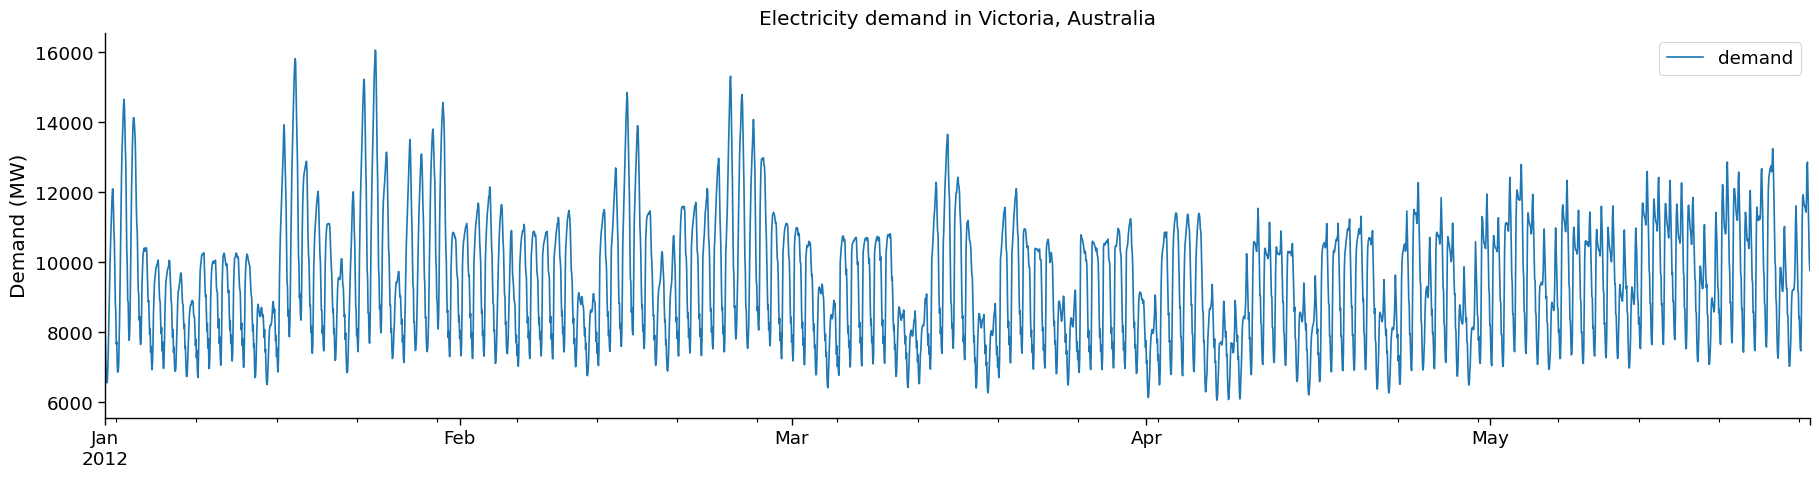

In [5]:
timeseries.plot()

plt.title("Electricity demand in Victoria, Australia")
plt.ylabel("Demand (MW)")
plt.xlabel("")
plt.show()

## 2) EDA

In [6]:
# Compute date time variables used later in plotting
timeseries["week"] = timeseries.index.isocalendar().week
timeseries["day_of_month"] = timeseries.index.day
timeseries["month"] = timeseries.index.month

timeseries.head()

,demand,week,day_of_month,month
date_time,,,,
2012-01-01 00:00:00,"7,926.5294",52,1,1
2012-01-01 01:00:00,"7,901.8270",52,1,1
2012-01-01 02:00:00,"7,255.7213",52,1,1
2012-01-01 03:00:00,"6,792.5034",52,1,1
2012-01-01 04:00:00,"6,635.9845",52,1,1


In [7]:
timeseries["month"].unique()

array([1, 2, 3, 4, 5], dtype=int32)

### 2.1) Daily seasonality
We see that there is daily seasonality (not flat lines).    
In the summer months (e.g., January) there is a daily peak around 4 PM whereas in the winter months (e.g., May) there are now two peaks, one around 8 AM and another around 6 PM. 

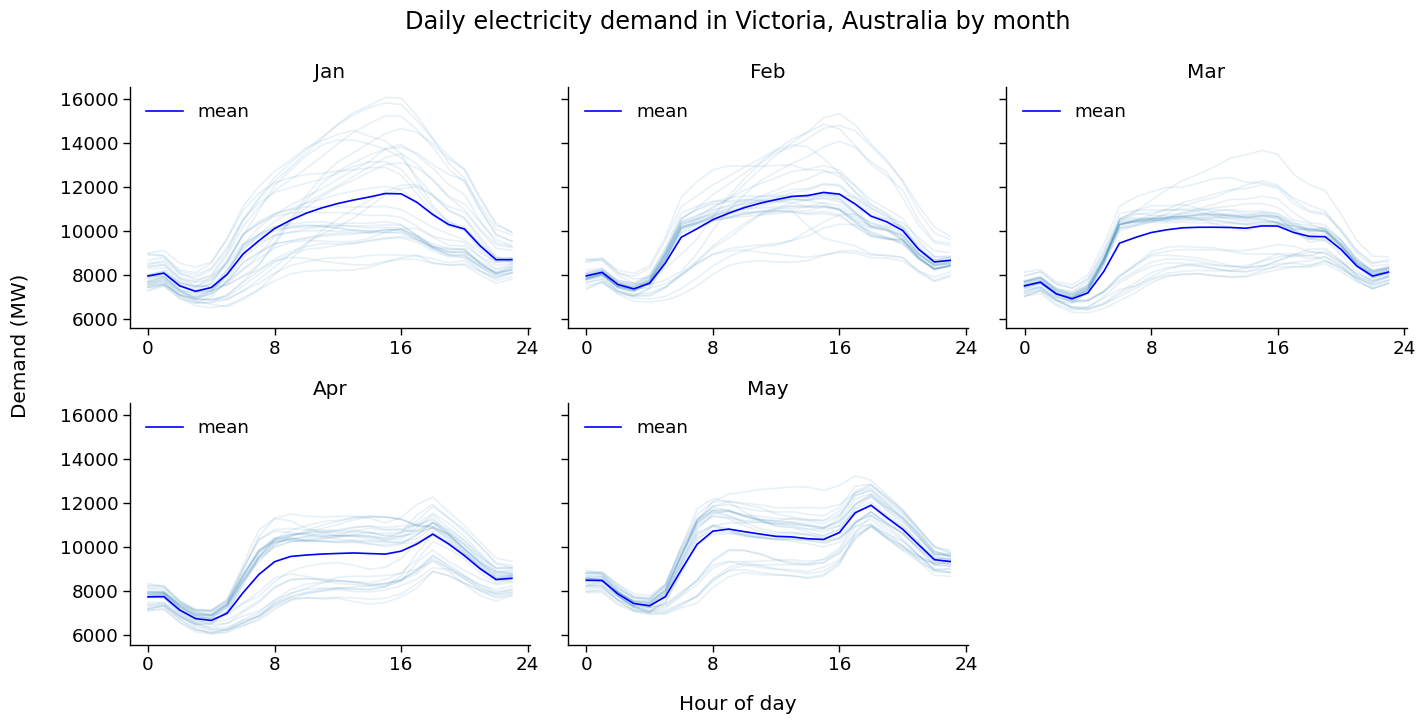

In [20]:
# Plot vars
sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May"]
ALPHA = 0.1

# Plot daily frequency by month
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[14, 7], sharey=True)
ax = ax.flatten()

for ix, month in enumerate(MONTHS): 
    daily_ts = []
    iter_month_df = timeseries[["demand", "day_of_month", "month"]].query(f"month == {ix+1}").groupby(["day_of_month"])
    for _, ts in (iter_month_df):
        ts = ts.reset_index()
        daily_ts.append(ts["demand"]) 
        ts["demand"].plot(ax=ax[ix], color=sns_blue, label="_no_legend_", alpha=ALPHA)
        ax[ix].set_xticks(np.arange(0, len(ts) + 1, 8))
        ax[ix].set_title(month)
    # Plot average electricity demand at each hour of the day
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(ax=ax[ix], color="blue", label="mean", legend=True) 
    ax[ix].legend(loc="upper left", frameon=False)

fig.text(0.5, -0.02, "Hour of day", ha="center")
fig.text(-0.02, 0.5, "Demand (MW)", va="center", rotation="vertical")
fig.suptitle("Daily electricity demand in Victoria, Australia by month")
fig.delaxes(ax[-1])
fig.tight_layout()

### 2.2) Weekly seasonality

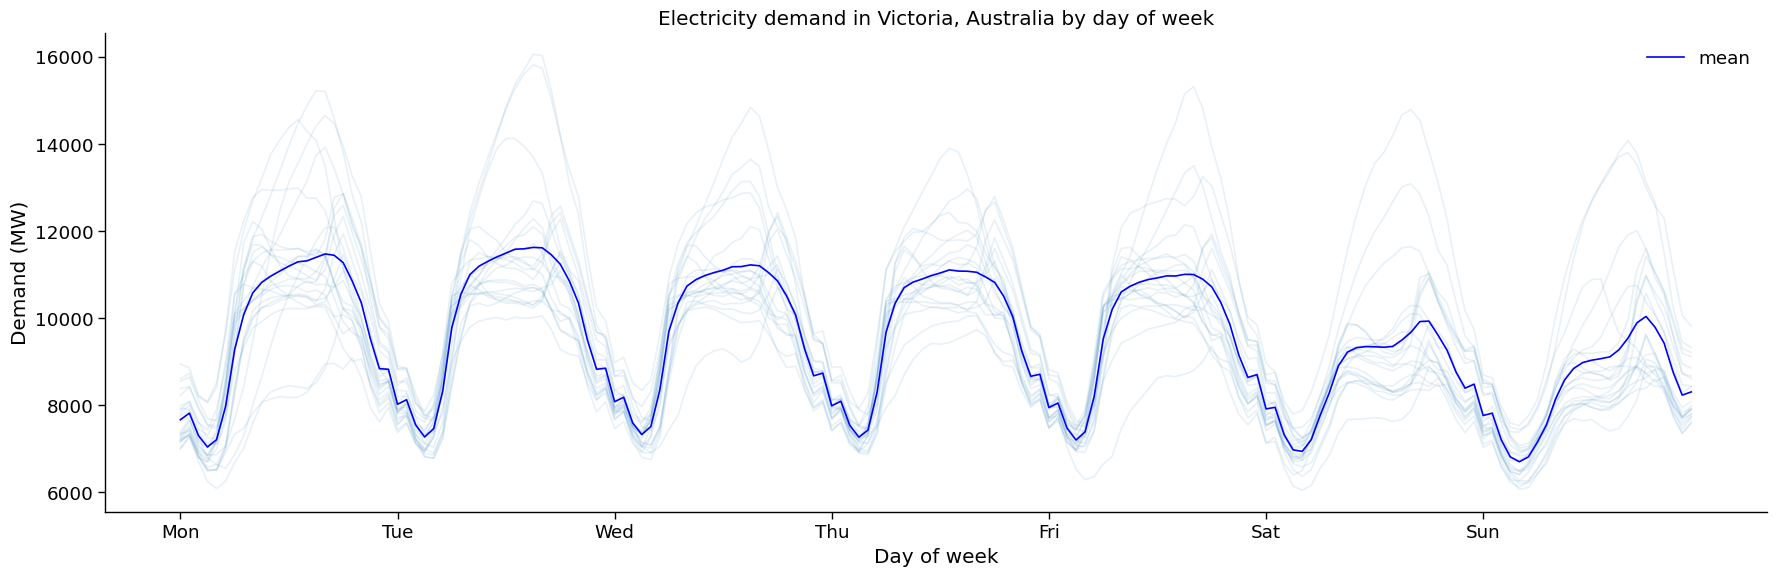

In [23]:
# Plot vars
sns_blue = sns.color_palette(as_cmap=True)
DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ALPHA = 0.1

# Plot
fig, ax = plt.subplots(figsize=[18, 6])
weekly_ts = []
for week, ts in timeseries.groupby("week"):
    ts = ts.reset_index()
    weekly_ts.append(ts["demand"])
    ts["demand"].plot(ax=ax, alpha=ALPHA, label="_no_legend_", color=sns_blue)
    plt.xticks(ticks=np.arange(0, 167, 24), labels=DAYS)

# Mean 
pd.concat(weekly_ts, axis=1).mean(axis=1).plot(ax=ax, color="blue", label="mean", legend=True)

ax.set_ylabel("Demand (MW)")
ax.set_title("Electricity demand in Victoria, Australia by day of week")
ax.set_xlabel("Day of week")
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()

## 3) MSTL
MSTL parameters
* `periods`: For our case which is a hourly data with daily and weekly seasonality, we would have: `periods=(24, 24*7)`
* `windows`: Smoothing parameter associated with each seasonal components. According to the defaul paper values are: `7+4*i`
* `lmbda`: The lambda parameter for a Box-Cox transformation prior to decompostiont. This is important if you do not want to assume your time seris is additive. Addtionally, you can use the `Guerrero` method to estimate the lambda parameter. If `None` then no transformation, if `auto` by MLE.
* `iterate`:  Number of iterations to use to refine the seasonal component. Default = 2.
* `stl_kwargs` - All the other parameters which can be passed to STL (e.g., `robust`, `seasonal_deg`, etc.). See [STL docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html).

The algorithm proposed in the paper handles a case when there is no seasonality. This implementation assumes that there is at least one seasonal component.

**NOTE**: remember the differences between: `LOWESS` vs. `LOESS`, where the later one uses a polynomial regression, and `d` or `seasonal_deg` can be:
* d=1: LOWESS == LOESS
* d=2: quadratic 
* d=0: average

To re-do the results of the paper we set the polynomial degree (d) = 0.

In [28]:
PERIODS = (24, 24*7)

mstl = MSTL(timeseries["demand"], 
            periods=PERIODS, 
            stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

In [29]:
res.trend.head()

date_time
2012-01-01 00:00:00   10,375.7317
2012-01-01 01:00:00   10,365.2596
2012-01-01 02:00:00   10,354.7910
2012-01-01 03:00:00   10,344.3260
2012-01-01 04:00:00   10,333.8648
Name: trend, dtype: float64

In [30]:
res.seasonal.head()

,seasonal_24,seasonal_168
date_time,,
2012-01-01 00:00:00,"-1,694.7998",-165.2829
2012-01-01 01:00:00,"-1,602.2671",-231.7710
2012-01-01 02:00:00,"-2,205.3301",-260.7932
2012-01-01 03:00:00,"-2,455.8806",-387.5940
2012-01-01 04:00:00,"-2,372.2009",-656.5227


In [31]:
res.resid.head()

date_time
2012-01-01 00:00:00   -589.1197
2012-01-01 01:00:00   -629.3945
2012-01-01 02:00:00   -632.9463
2012-01-01 03:00:00   -708.3480
2012-01-01 04:00:00   -669.1568
Name: resid, dtype: float64

### 3.1) Plot MSTL decomposition

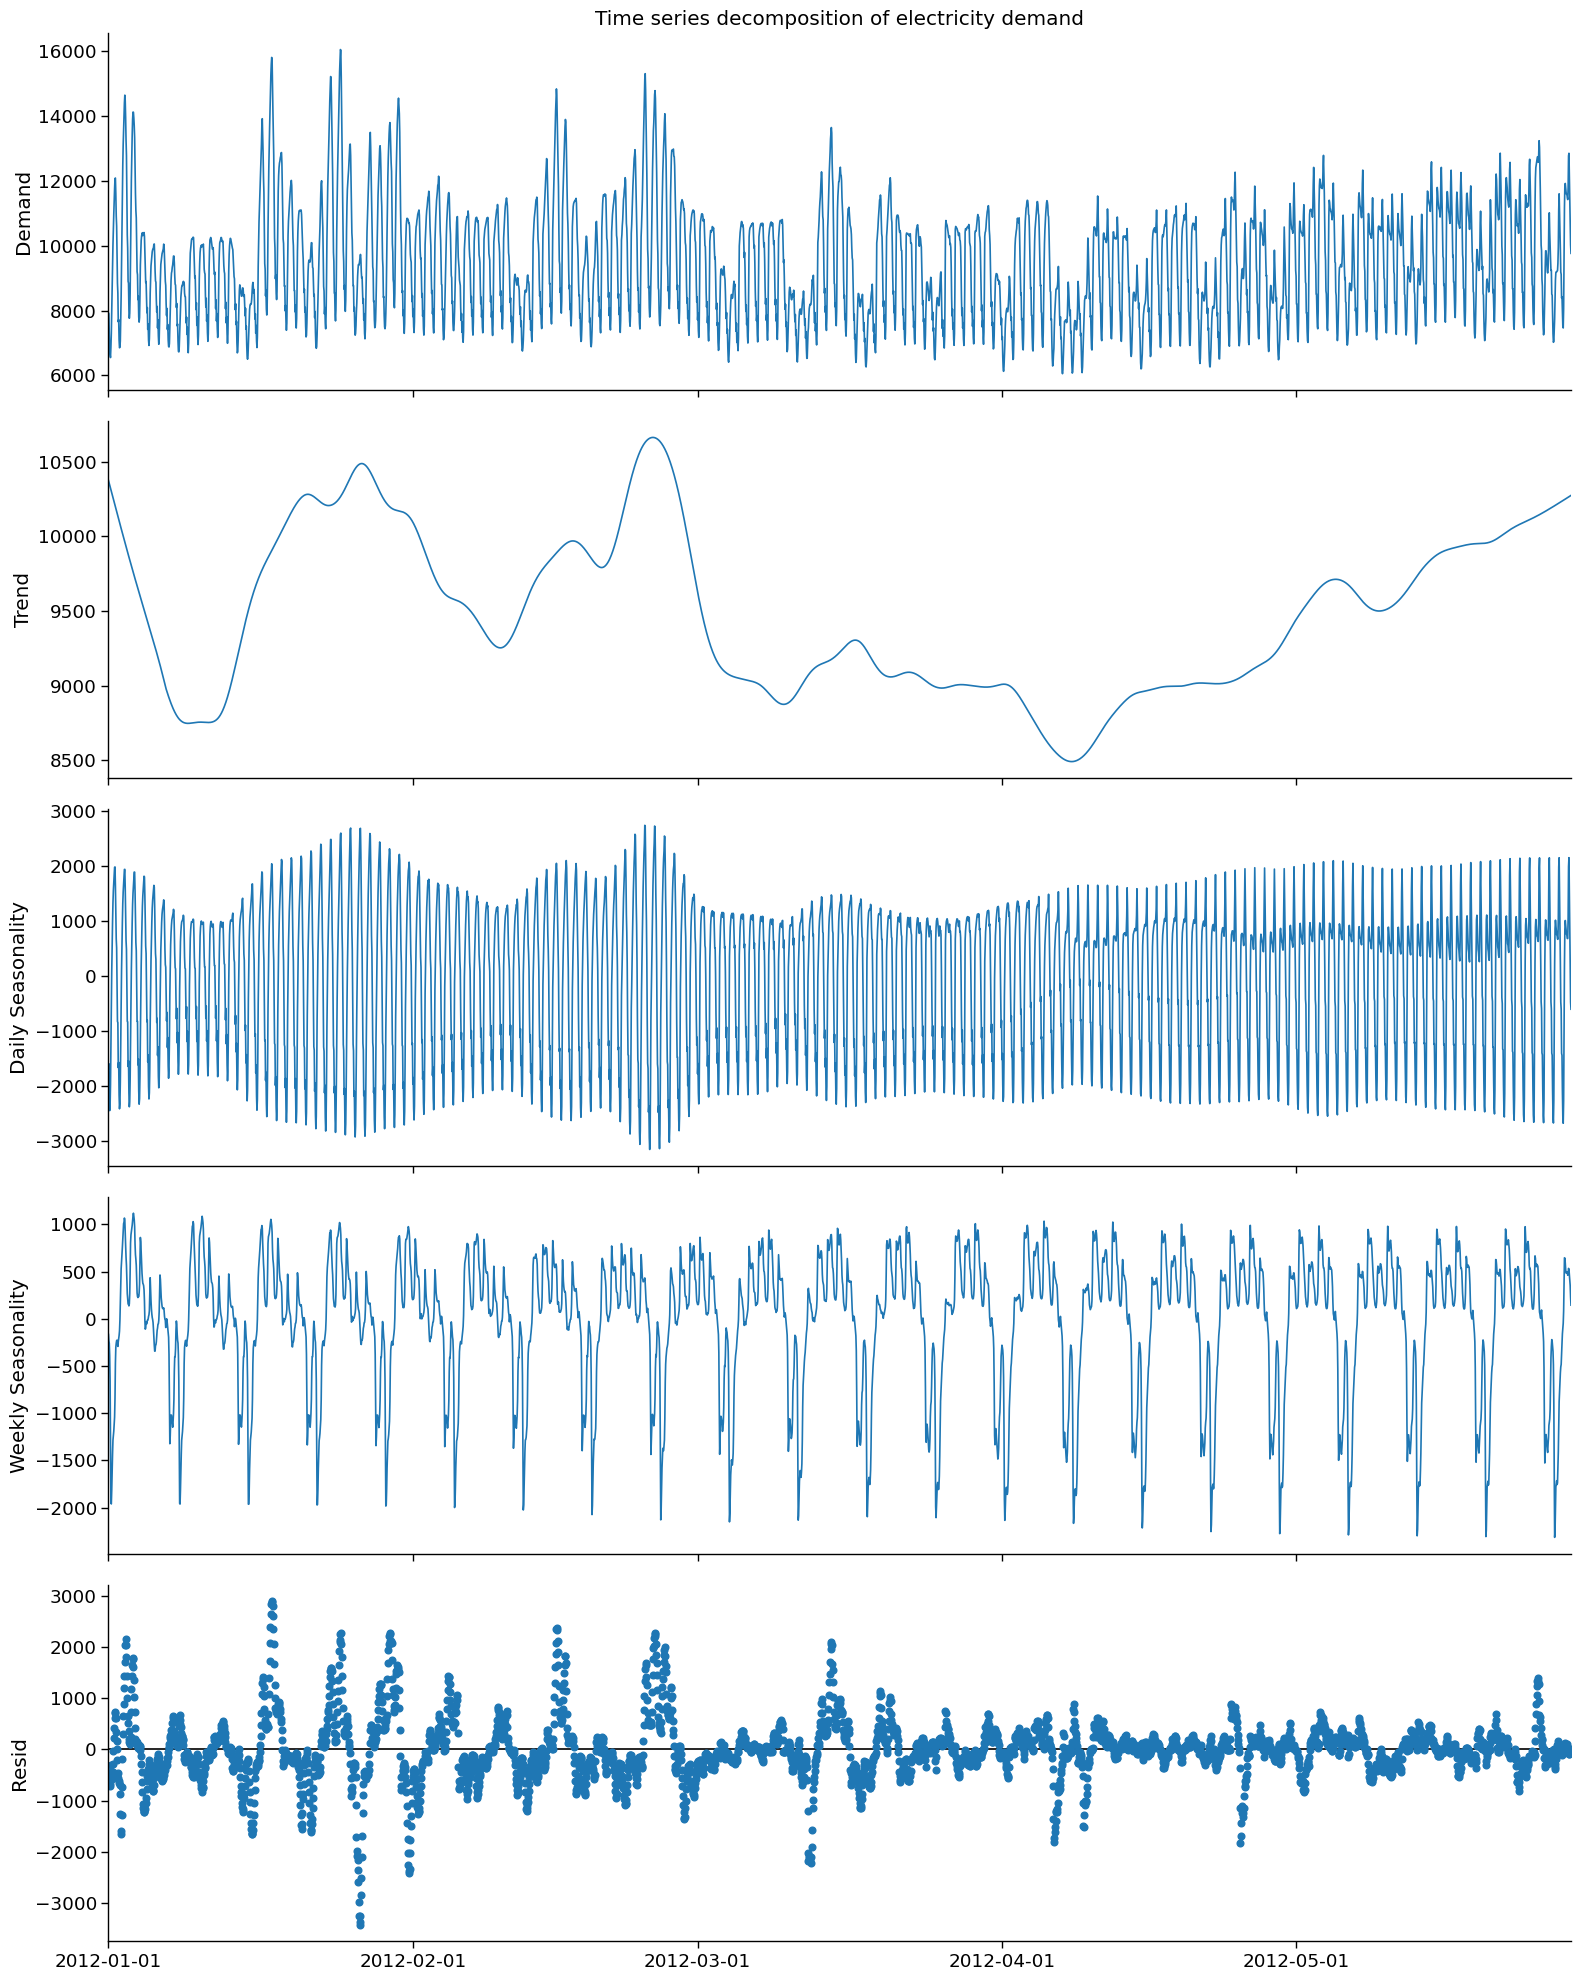

In [44]:
plt.rc("figure", figsize=(16,20))
plt.rc("font", size=13)
fig = res.plot()

axs = fig.get_axes()
ax_last = axs[-1]
ax_last.xaxis.set_ticks(pd.date_range(start="2012-01-01", freq="MS", periods=5))

axs[0].set_ylabel("Demand")
axs[0].set_title("Time series decomposition of electricity demand")
axs[2].set_ylabel("Daily Seasonality")
axs[3].set_ylabel("Weekly Seasonality")

plt.tight_layout()

### 3.2) Explore Daily Seasonality

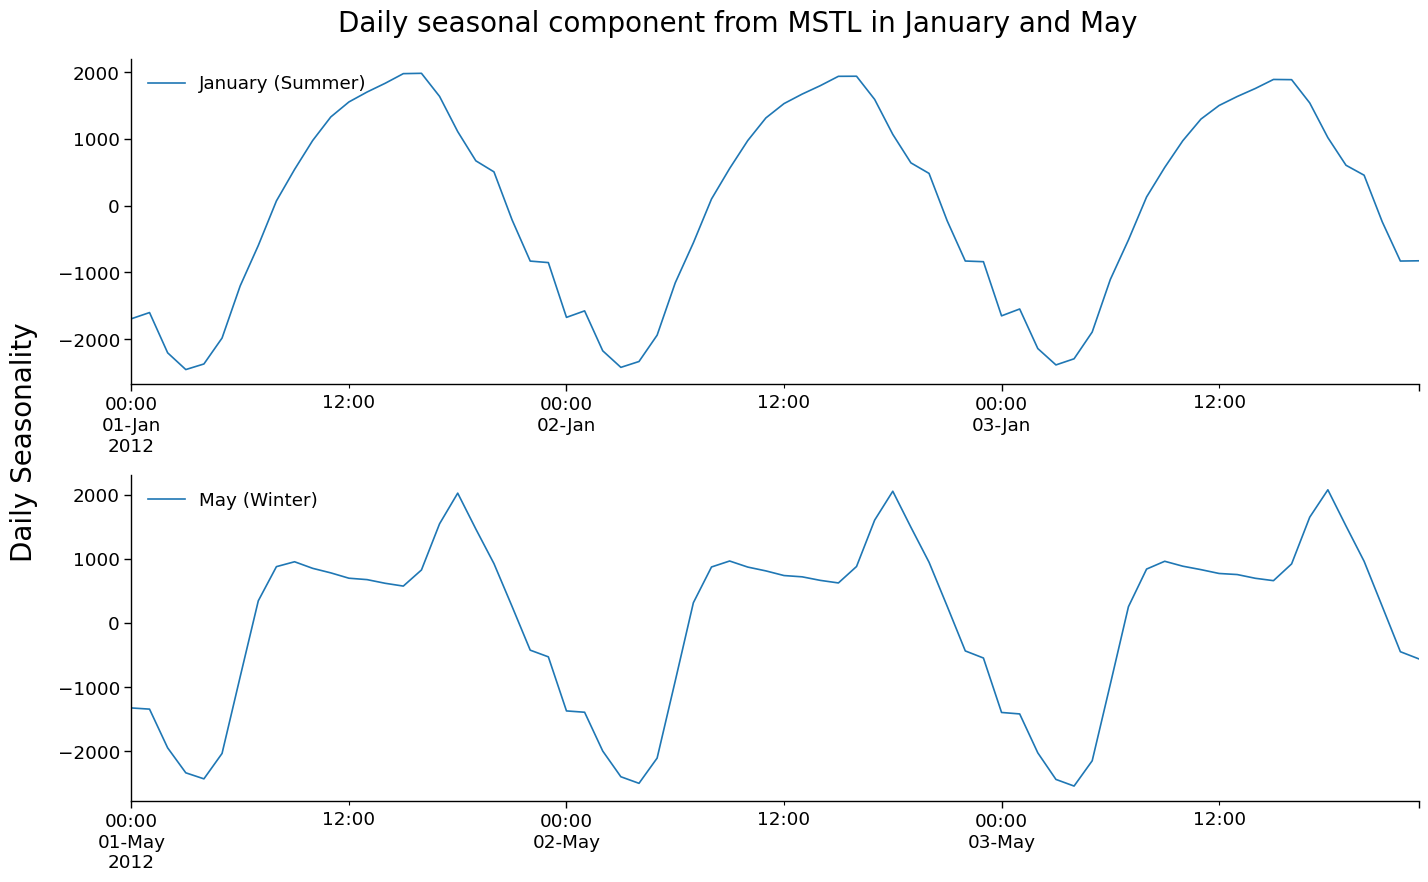

In [80]:
NUM_DAYS = 3

fig, ax = plt.subplots(nrows=2, figsize=[14, 9])
ax = ax.flatten()

# January
res.seasonal["seasonal_24"].iloc[:24*NUM_DAYS].plot(ax=ax[0], label="January (Summer)", legend=True)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="upper left", frameon=False)

# May
mask = res.seasonal.index.month == 5
res.seasonal[mask]["seasonal_24"].iloc[: 24*NUM_DAYS].plot(ax=ax[1], label="May (Winter)", legend=True)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="upper left", frameon=False)

fig.suptitle("Daily seasonal component from MSTL in January and May", fontsize=20)
fig.text(-0.02, 0.5, "Daily Seasonality", va="center", rotation="vertical", fontsize=20)

plt.tight_layout()

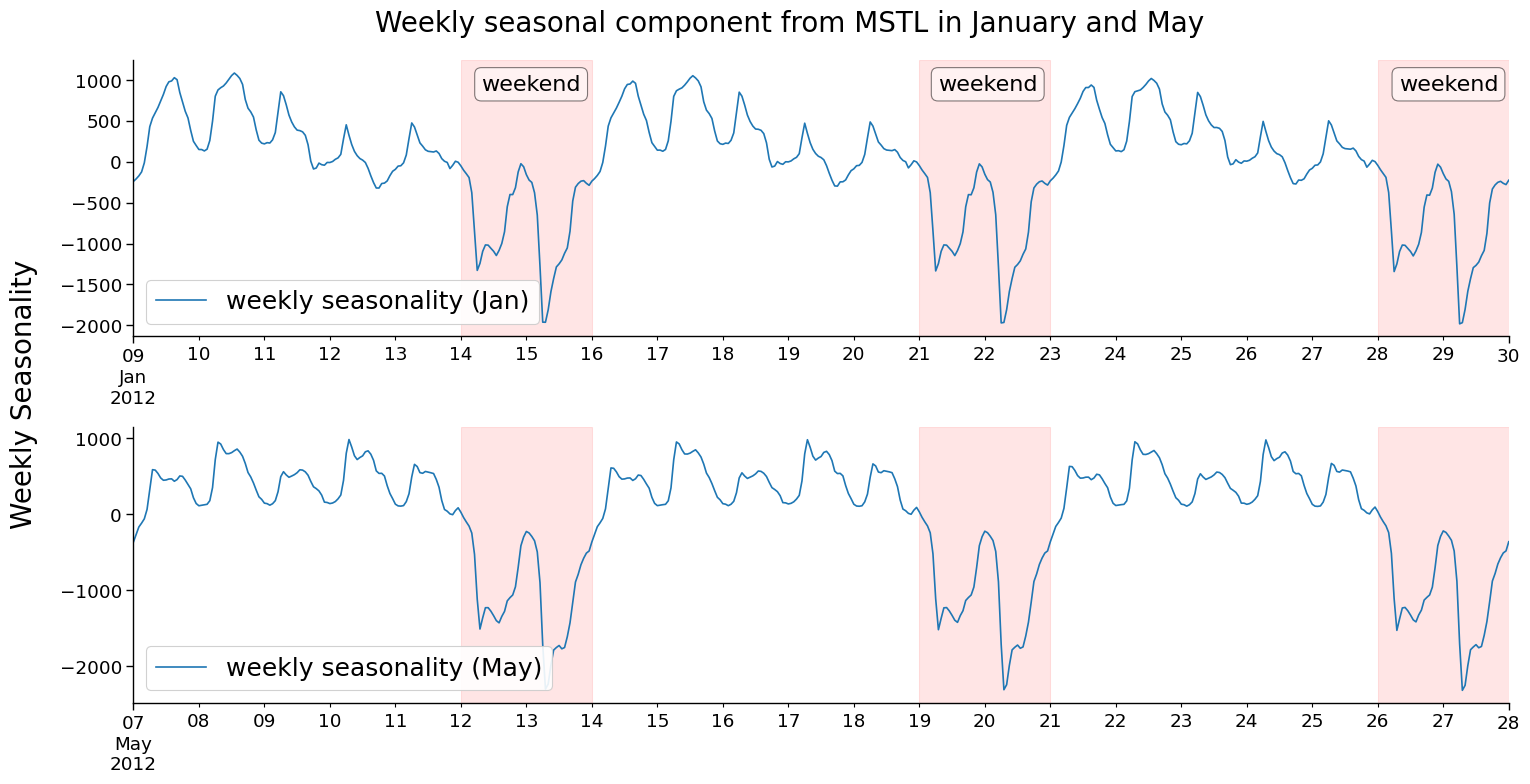

In [88]:
fig, ax = plt.subplots(nrows=2, figsize=[15, 8])
ax = ax.flatten()

# Plot weekly seasonality in January
start = pd.Timestamp("2012-01-09")  # Monday
end = start + pd.Timedelta("3W")
res.seasonal["seasonal_168"].loc[start:end].plot(
    ax=ax[0], label="weekly seasonality (Jan)", legend=True
)
ax[0].set_ylabel("seasonal_168")
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].legend(loc="lower left", framealpha=0.9, fontsize=18)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.253,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.585,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
ax[0].text(
    0.92,
    0.95,
    "weekend",
    transform=ax[0].transAxes,
    fontsize=16,
    verticalalignment="top",
    bbox=props,
)

weekends = [
    ("2012-01-14", "2012-01-16"),
    ("2012-01-21", "2012-01-23"),
    ("2012-01-28", "2012-01-30"),
]
for start_, end_ in weekends:
    ax[0].axvspan(start_, end_, alpha=0.1, color="red")

# Plot weekly seasonality in May
mask = res.seasonal.index.month == 5
start = pd.Timestamp("2012-05-7")
end = start + pd.Timedelta("3W")
res.seasonal[mask]["seasonal_168"].loc[start:end].plot(
    ax=ax[1], label="weekly seasonality (May)", legend=True
)
ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].legend(loc="lower left", framealpha=0.9, fontsize=18)

weekends = [
    ("2012-05-12", "2012-05-14"),
    ("2012-05-19", "2012-05-21"),
    ("2012-05-26", "2012-05-28"),
]
for start_, end_ in weekends:
    ax[1].axvspan(start_, end_, alpha=0.1, color="red")

fig.suptitle("Weekly seasonal component from MSTL in January and May", fontsize=20)
fig.text(-0.02, 0.5, "Weekly Seasonality", va="center", rotation="vertical", fontsize=20)

plt.tight_layout()